In [1]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from matplotlib.lines import Line2D
from pandas.tseries.offsets import MonthEnd
from scipy.optimize import minimize
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error as root_mse

sns.set(style="white")

# Données

In [2]:
model_data_no_journal = pd.read_parquet("data/model_data_no_journal.parquet")
model_data = pd.read_parquet("data/model_data.parquet")

# model_data_no_journal = model_data_no_journal[model_data_no_journal['political_alignment'] != 'autre']
# model_data = model_data[model_data['political_alignment'] != 'autre']

Indicatrices temporelles :
- `pres_dummy` = 3 mois précédant une élection présidentielle
- `europ_dummy_short` = 3 mois suivant une élection européenne
- `europ_dummy_long` = d'une élection européenne à l'élection présidentielle suivante

In [3]:
model_data['next_pres_votes_share'] = model_data['pres_dummy'] * model_data['pres_votes_share']
model_data['europ_votes_short'] = (model_data['europ_votes_share'] * model_data_no_journal['europ_dummy_short'])
model_data['europ_votes_long'] = (model_data['europ_votes_share'] * model_data_no_journal['europ_dummy_long'])

model_data_no_journal['next_pres_votes_share'] = model_data_no_journal['pres_dummy'] * model_data_no_journal['pres_votes_share']
model_data_no_journal['europ_votes_short'] = (model_data_no_journal['europ_votes_share'] * model_data_no_journal['europ_dummy_short'])
model_data_no_journal['europ_votes_long'] = (model_data_no_journal['europ_votes_share'] * model_data_no_journal['europ_dummy_long'])

In [4]:
nuances_order = ["Far right", "Right", "Center", "Left", "Far left", "Other"]

In [5]:
presi_dates = [
    "26/04/1981", "10/05/1981",
    "24/04/1988", "08/05/1988",
    "23/04/1995", "07/05/1995",
    "21/04/2002", "05/05/2002",
    "22/04/2007", "06/05/2007",
    "22/04/2012", "06/05/2012",
    "21/04/2017", "07/05/2017",
    "10/04/2022", "24/04/2022"]
presi_months = pd.to_datetime(presi_dates, dayfirst=True).to_period('M').drop_duplicates()

legi_dates = [
    "14/06/1981", "21/06/1981",
    "16/03/1986",
    "05/06/1988", "11/06/1988",
    "21/03/1993", "28/03/1993",
    "25/05/1997", "01/06/1997",
    "09/06/2002", "16/06/2002",
    "10/06/2007", "17/06/2007",
    "10/06/2012", "17/06/2012",
    "11/06/2017", "18/06/2017",
    "12/06/2022", "19/06/2022",
    "29/06/2024", "06/07/2024"]
legi_months = pd.to_datetime(legi_dates, dayfirst=True).to_period('M').drop_duplicates()

regio_dates = [
    "16/03/1986",
    "22/03/1992",
    "15/03/1998",
    "21/03/2004", "28/03/2004",
    "14/03/2010", "21/03/2010",
    "06/12/2015", "13/12/2015",
    "20/06/2021", "27/06/2021"]
regio_months = pd.to_datetime(regio_dates, dayfirst=True).to_period('M').drop_duplicates()

canto_dates = [
    "14/03/1982", "21/03/1982",
    "10/03/1985", "17/03/1985",
    "25/09/1988", "02/10/1988",
    "20/03/1992", "27/03/1992",
    "15/03/1998", "22/03/1998",
    "11/03/2001", "18/03/2001",
    "21/03/2004", "28/03/2004",
    "9/03/2008", "16/03/2008",
    "20/03/2011", "27/03/2011"]
canto_months = pd.to_datetime(canto_dates, dayfirst=True).to_period('M').drop_duplicates()

dept_dates = [
    "22/03/2015", "29/03/2015",
    "20/06/2021", "27/06/2021"]
dept_months = pd.to_datetime(dept_dates, dayfirst=True).to_period('M').drop_duplicates()

muni_dates = [
    "06/03/1983", "13/03/1983",
    "12/03/1989", "19/03/1989",
    "11/06/1995", "18/06/1995",
    "11/03/2001", "18/03/2001",
    "09/03/2008", "16/03/2008",
    "23/03/2014", "30/03/2014",
    "15/03/2020", "28/06/2020"]
muni_months = pd.to_datetime(muni_dates, dayfirst=True).to_period('M').drop_duplicates()

europ_dates = [
    "17/06/1984",
    "18/06/1989",
    "12/06/1994",
    "13/06/1999",
    "13/06/2004",
    "07/06/2009",
    "25/05/2014",
    "26/05/2019",
    "09/06/2024"]
europ_months = pd.to_datetime(europ_dates, dayfirst=True).to_period('M').drop_duplicates()

main_elec_dates = presi_dates + legi_dates + europ_dates
main_elec_months = pd.to_datetime(main_elec_dates, dayfirst=True).to_period('M').drop_duplicates().sort_values()

other_elec_dates = regio_dates + canto_dates + dept_dates + muni_dates
other_elec_months = pd.to_datetime(other_elec_dates, dayfirst=True).to_period('M').drop_duplicates().sort_values()

def add_shaded_periods(ax_list, periods, color, alpha):
    start_period = None
    for i, period in enumerate(periods):
        if start_period is None:
            start_period = period
        is_last = (i == len(periods) - 1)
        is_gap = (not is_last and periods[i + 1] != period + 1)
        if is_last or is_gap:
            end_period = period
            start = start_period.to_timestamp()
            end = (end_period + MonthEnd(1)).to_timestamp()
            for ax in ax_list:
                ax.axvspan(start, end, color=color, alpha=alpha)
            start_period = None

# Cadre

## Approche
Nous cherchons à expliquer le volume des citations attribuées aux différentes nuances politiques, qui reflète le degré auquel la parole leur est donnée. Sa modélisation économétrique est délicate pour trois raisons.
1. **Les pratiques journalistiques sont fortement normées.** Elles sont soumises à un principe de neutralité, se traduisant par une norme de représentativité : la couverture des partis politiques, et des personnalités qui les représentent, doit refléter leur importance dans la vie politique. Le volume des citations ne peut donc s'interpréter qu'en relation à cette norme. Dans quelle mesure est-elle suivie ? L'est-elle à l'identique par toutes les rédactions, pour toutes les nuances politiques, à toutes les périodes ?
2.	**Le volume des citations subit des tendances importantes sur la période étudiée**, en raison principalement du basculement de l'imprimé vers Internet. Or, ces tendances sont décorrélées des potentiels régresseurs, car leur importance dans la vie politique ne peut croître ou se réduire simultanément pour toutes les nuances politiques. Cela rend difficile l'élimination des tendances, les effets fixes capturant l'essentiel des relations au détriment des régresseurs. Le seul remède est de normaliser le volume des citations en se ramenant aux proportions des citations attribuées à chaque nuance politique. Mais l'on se heurte alors de manière particulièrement visible à la difficulté suivante.
3.	**Les données présentent une double compositionnalité**, c'est-à-dire qu'elles sont des fractions de sommes stables.
  - C'est bien le cas des proportions de citations, dont la somme est par construction égale à un, mais aussi du volume des citations, dans la mesure où leur nombre total est contraint à court terme : les journaux ne peuvent citer un nombre infini de personnalités à chaque période, car le nombre d'articles qu'ils publient est limité par des enjeux de production et de diffusion. Ils doivent donc décider comment ils répartissent articles et citations entre les nuances politiques, ce qui engendre des dépendances complexes : toute citation attribuée à une nuance politique est aussi non-attribuée aux autres.
  - Il en va de même pour les régresseurs. Considérons par exemple les résultats électoraux : le nombre total d'électeurs étant fixé à chaque élection, toute voix obtenue par un parti est aussi une voix dont sont privés les autres.
  - Or, il existe des instruments statistiques permettant de traiter la compositionnalité des outcomes, notamment les régressions Dirichlet, mais il est extrêmement compliqué d'y intégrer la compositionnalité des régresseurs, alors que leur interprétation peut s'avérer très délicate. Les instruments statistiques traditionnels, pour leur part, risquent d'aboutir à des résultats incohérents : typiquement, une somme des proportions des citations attribuées à chaque nuance politique supérieure à un, signifiant que l'effet des régresseurs est surestimé.

Nous proposons une solution ne cherchant pas à modéliser le plus précisément possible des phénomènes réels, mais à étudier leur écart à des phénomènes de référence. Cette approche prend sens relativement au caractère normé des activités journalistiques. Elle consiste à estimer les proportions des citations attribuées à chaque nuance politique qu'on devrait observer si les journalistiques respectaient parfaitement la norme de représentativité, c'est-à-dire les proportions ***normales***, pour mesurer à quel point les proportions effectives s'en écartent.

Dans cette perspective, la légitimation / normalisation de l'ED pourrait prendre deux formes.
1.	Une déconnexion croissante entre sa couverture médiatique et son importance dans la vie politique, en partant d'une situation où la norme de représentativité était respectée, les journalistes citent davantage les personnalités d'ED qu'ils ne le devraient, et ne le faisaient initialement.
2.	Une connexion croissante, en partant d'une situation où la norme n'était pas respectée, car l'ED était diabolisée : les journalistes citent autant les personnalités d'ED qu'ils le doivent, alors qu'ils les citaient moins initialement.

Cette approche permet de respecter les contraintes découlant de la compositionnalité des données tout en fournissant des résultats interprétables, car demeurant dans le cadre d'un modèle linéaire. En effet, la norme de représentativité devrait engendrer une proportionnalité entre l'importance des partis dans la vie politique et leur couverture, autrement dit, une relation linéaire.

In [6]:
outcome = "quotes_share"

## Spécification de la norme
Formalisons maintenant cette norme. Indiçons par $i$ les nuances politiques ($n$ au total) et $t$ les périodes, puis notons $Y_{it}$ la proportion des citations reçues par la nuance $i$ à la période $t$ et $Y_{it}^{norm}$ qu'elle devrait normalement recevoir. 
Supposons également qu'à chaque période :
- Chaque nuance reçoit une fraction incompressible des citations, c'est-à-dire qu'elle bénéficie d'une couverture médiatique minimale même lorsque son poids électoral et institutionnel est nul. Cette fraction est notée $\alpha$. L'hypothèse $\alpha>0$ est plausible dans la mesure où les nuances politiques rassemblent plusieurs partis, et où l'un au moins de ces partis est toujours suffisamment important pour recevoir l'attention des journalistes. 
- La nuance politique au gouvernement reçoit une fraction fixe des citations, notée $\theta$, reflétant la couverture médiatique de l'action gouvernementale (en notant $G_{it}$ l'indicatrice valant 1 si le Premier ministre appartient à la nuance politique $i$ durant la période $t$).
- Les citations restantes sont réparties entre les nuances politiques en fonction de leur poids dans la vie politique, estimé par la moyenne pondérée de la proportion des sièges qu'elles détiennent à l'Assemblée nationale (notée ${AN}_{it}$ et pondérée par $\beta$) et du score qu'elles ont obtenu au premier tour de la dernière élection présidentielle (notée $P_{it}$ et pondérée par $\gamma$).
- <span style="background-color: yellow">*Justifications à détailler*</span>

La norme de représentativité se manifeste alors par la relation suivante : 
$$Y_{it}^{norm} = \alpha + \beta AN_{it} + \gamma P_{it} + \theta G_{it}$$
 
L'identité des coefficients sont identiques pour l'ensemble des nuances politiques et des périodes signifie que la norme s'applique de la même façon à l'ensemble du spectre politique, et n'évolue pas au cours du temps (par exemple avec un poids croissant accordé à l'action gouvernementale). 
 
Par ailleurs, dans la mesure où les élections présidentielles et législatives se suivent généralement de près, ce modèle normatif prévoit des proportions de citations constantes au cours des cycles électoraux. Il ne s'agit évidemment pas d'un phénomène que nous imaginons observer, en particulier car la couverture médiatique de la vie politique reflète de nombreuses dynamiques transitoires. Mais à moyen terme ou à l'échelle des cycles électoraux, les proportions des citations devraient graviter autour de leurs valeurs normales.

Les contraintes de compositionnalité sont les suivantes ($\forall t$) :
- $\sum_{i=1}^{n} Y_{it} = 1$
- $\sum_{i=1}^{n} {AN}_{it} = 1$
- $\sum_{i=1}^{n} P_{it} = 1$
- $\sum_{i=1}^{n} G_{it} = 1$
 
Les contraintes d'interprétations, impliquant notamment des relations positives, sont les suivantes :
- $0< \alpha <1$ 
- $0< \theta <1$ 
- $0< \beta, \gamma <1$ et $\beta + \gamma = 1$ 
 
Et l'on doit bien sûr avoir $\forall (i,t) : 0 < Y_{it}^{norm} < 1$ 
 
Ces conditions sont vérifiées en spécifiant le modèle ainsi : 
$$Y_{it}^{norm} = \alpha + (1 - n*alpha - \theta)(\beta {AN}_{it} + \gamma P_{it}) + \theta G_{it}$$

Comment déterminer la valeur de ces coefficients ? Une première possibilité est de les estimer à partir des valeurs observées, en minimisant une fonction de perte (typiquement l'erreur quadratique) sous les contraintes précédentes. Cette approche est problématique pour au moins trois raisons.
1.	Les données ne sont pas homogènes : elles ne sont pas disponibles pour tous les journaux à toutes les périodes, signifiant que certains vont peser davantage dans l'estimation. Cela risque d'engendrer des biais implicites, car l'estimation reflètera davantage les pratiques de certaines rédactions que les comportements moyens des journalistes.
2.	Si la norme de représentativité est peu respectée, les résultats conduiront à sous-estimer les déviations qui s'opèrent en pratique.
3.	Une solution à ces deux difficultés serait de pouvoir identifier des situations dans lesquelles le respect de la norme est assurée, notamment en sélectionnant un journal et/ou une période de référence. Mais cela revient à prendre parti dans le champ médiatique, ce qui est contestable. Par ailleurs, quelles que soient les données utilisées pour l'estimation, l'existence d'une solution optimale n'est pas acquise : rien n'assure que le modèle dispose d'une solution unique et converge vers elle.

Une possibilité alternative consiste à spécifier les coefficients *a priori* à partir de sources externes sur les pratiques des rédactions, en posant par exemple :
- $\alpha = 0,02 \Rightarrow$ toute nuance politique reçoit au moins 2 % des citations.
- $\beta = 0,666$ et $\gamma = 0,333 \Rightarrow$ pour appréhender l'importance des nuances dans la vie politique, les journalistes accordent un poids de 2/3 à la proportion de députés qu'elles détiennent et 1/3 à leur score aux présidentielles.
- $\theta = 0,1 \Rightarrow$ la nuance politique au pouvoir reçoit 10 % des citations à ce titre.
- <span style="background-color: yellow">*Exemple numérique*</span>

## Mesure de la distance entre les valeurs normales et observées
Dans une approche économétrique classique, on s'intéresserait aux coefficients et à leur significativité pour interpréter les résultats du modèle. Cela aurait peu de sens ici, puisque les coefficients sont prédéfinis. A la place, on utilise plusieurs grandeurs pour mesurer l'écart entre les prescriptions du modèle et les valeurs observées, c'est-à-dire entre les comportements normaux et réels.
- Les $\text{mean residuals (MR)} = Y_{it} - Y_{it}^{norm}$
  - D'abord s'intéresser à leur signe : positif lorsqu'une nuance politique reçoit une proportion supérieure des citations à celle prescrite par la norme de représentativité, à une période donnée
  - Intérêt de leur moyenne pour évaluer le respect de la norme. Les écarts de signe opposé se compensent, or la norme est respectée même si beaucoup de fluctuations à court terme (avec un modèle qui serait considéré comme peu prédictif avec une approche économétrique classique).
  - <span style="background-color: yellow">*Exemple de lecture*</span>
  - <span style="background-color: yellow">*Calculer aussi leur variance*</span>
- Les $\text{mean relative residuals (MRR)} = \frac{Y_{it} - Y_{it}^{norm}}{Y_{it}^{norm}}$
  - Normalisation par rapport aux valeurs normales (plutôt qu'aux valeurs observées comme dans les approches économétriques classiques) car celles-ci priment dans l'interprétation
  - Permet de compenser les écarts entre les valeurs moyennes selon les nuances politiques. Mais risque d'engendrer des valeurs très élevées quand les valeurs normales sont faibles, plus délicat à interpréter.
  - <span style="background-color: yellow">*Exemple de lecture*</span>



Autres grandeurs qui servent davantage à mesurer la qualité prédictive, en revenant à une approche plus classique, qui considèrent les déviations en valeur absolue, sans compensation lorsqu'elles sont de signe opposé :
- $\text{Mean absolute percentage error (MAPE)} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{\hat{y}_i - y_i}{\hat{y}_i} \right| \Rightarrow$ Ils correspondent à la moyenne des résidus relatifs en valeur absolue, et s'interprètent directement : une MAPE de 1 signifie que les valeurs réelles s'écartent en moyenne de 100 % des valeurs prescrites, dans un sens ou dans l'autre.
- $\text{Root mean squared percentage error (RMSPE)} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} \Rightarrow$ Elle ne s'interprète pas directement mais permet aussi de comparer les modèles, en étant plus sensible aux outliers que la MAPE.

In [7]:
def mean_rr(y_true, y_pred):
    return ((y_true - y_pred) / y_pred).mean()

def mean_r(y_true, y_pred):
    return ((y_true - y_pred)).mean()

def mean_ape(y_true, y_pred):
    return ((np.abs(y_true - y_pred) / y_pred).mean())

## ...
La démarche actuelle consiste à comparer ces indicateurs selon les variables d'intérêt : nuances politiques, journaux, périodes et leurs interactions.
 
Une démarche plus formelle serait de régresser les résidus du modèle normatif sur les variables d'intérêt. 
- Elle doit revenir au même que la précédente en l'absence de constante dans les régressions, dont les coefficients correspondent alors aux moyennes des résidus observées sur les sous-populations définies par les modalités des variables d'intérêt.
- Mais elle permet probablement d'aller plus loin…

# Modèle normal

In [ ]:
n = len(model_data_no_journal['political_alignment'].unique())
y = model_data_no_journal[outcome]

In [39]:
alpha = 0.02
beta = 0.666
gamma = 0.333
theta = 0.1

y_norm = (
    alpha +
    beta * (1 - n*alpha - theta) * model_data_no_journal["na_share"] + 
    gamma * (1 - n*alpha - theta) * model_data_no_journal["pres_votes_share"] +
    theta * model_data_no_journal["government"])

r2 = r2_score(y, y_norm)
mr = mean_r(y, y_norm)
mrr = mean_rr(y, y_norm)
mape = mean_ape(y, y_norm)
rmspe = root_mse(y, y_norm)

print(f"R2: {100*r2:.2f}%")
print(f"MR: {100*mr:.2f}%")
print(f"MRR: {100*mrr:.2f}%")
print(f"MAPE: {100*mape:.2f}%")
print(f"RMSPE: {rmspe:.5f}")

R2: 79.91%
MR: 3.44%
MRR: 3.66%
MAPE: 55.78%
RMSPE: 0.10554


<span style="background-color: yellow">*Commentaire*</span>

## Tentative de détermination des valeurs optimales

In [35]:
# Minimizing RMSPE (as in OLS models)
def objective(params):
    alpha, beta, theta = params[0], params[1], params[2]
    gamma = 1 - beta
    y_pred = (
        alpha +
        beta * (1 - n * alpha - theta) * model_data_no_journal["na_share"] +
        gamma * (1 - n * alpha - theta) * model_data_no_journal["pres_votes_share"] +
        theta * model_data_no_journal["government"]
    )
    return root_mse(y, y_pred)

initial_guess = [0.01, 0.5, 0.1]

result = minimize(
    objective,
    initial_guess,
    bounds=[(0, 1), (0, 1), (0, 1)],
    method='SLSQP')

if result.success:
    alpha_opt, beta_opt, theta_opt = result.x
    gamma_opt = 1 - beta_opt
    print(f"Optimal alpha: {alpha_opt:.5f}")
    print(f"Optimal beta: {beta_opt:.5f}")
    print(f"Optimal gamma: {gamma_opt:.5f}")
    print(f"Optimal theta: {theta_opt:.5f}")
else:
    print("Optimization failed:", result.message)

Optimal alpha: 0.00000
Optimal beta: 0.82972
Optimal gamma: 0.17028
Optimal theta: 0.02228


In [36]:
y_norm = (
    alpha_opt +
    beta_opt * (1 - n*alpha_opt - theta_opt) * model_data_no_journal["na_share"] + 
    gamma_opt * (1 - n*alpha_opt - theta_opt) * model_data_no_journal["pres_votes_share"] +
    theta_opt * model_data_no_journal["government"])

r2 = r2_score(y, y_norm)
mr = mean_r(y, y_norm)
mrr = mean_rr(y, y_norm)
mape = mean_ape(y, y_norm)
rmspe = root_mse(y, y_norm)

print(f"R2: {100*r2:.2f}%")
print(f"MR: {100*mr:.2f}%")
print(f"MRR: {100*mrr:.2f}%")
print(f"MAPE: {100*mape:.2f}%")
print(f"RMSPE: {rmspe:.5f}")

R2: 84.01%
MR: 2.27%
MRR: inf%
MAPE: inf%
RMSPE: 0.09416


## Régression des résidus

In [12]:
X = pd.get_dummies(model_data_no_journal['political_alignment'], prefix='alignment')
X = X.drop(columns='alignment_Other')
#X = sm.add_constant(X)
type(X)

pandas.core.frame.DataFrame

In [13]:
X = pd.get_dummies(model_data_no_journal['political_alignment'], prefix='alignment')
X = X.drop(columns='alignment_Other')
# X = sm.add_constant(X)
model = sm.OLS(y_norm, X).fit(cov_type='HC3')

y_pred = model.predict(X)

r2 = r2_score(y_norm, y_pred)

params = model.params.rename("coef").to_frame()
pvalues = model.pvalues.rename("pval").to_frame()
print(pd.merge(params, pvalues, left_index=True, right_index=True))
print("")
print(f"R2: {100*r2:.2f}%")

                         coef          pval
alignment_Center     0.176155  3.493963e-41
alignment_Far left   0.080046  0.000000e+00
alignment_Far right  0.058379  0.000000e+00
alignment_Left       0.297765  0.000000e+00
alignment_Right      0.377928  0.000000e+00

R2: 56.04%


In [14]:
# mais revient juste à calculer la moyenne des résidus par orientation politique
model_data_no_journal['y_norm'] = y_norm
model_data_no_journal[model_data_no_journal['political_alignment'] == "Center"]['y_norm'].mean()

np.float64(0.17615489696186445)

In [15]:
val1 = alpha + beta*(1-3*alpha-theta)*0.6 + gamma*(1-3*alpha-theta)*0.6 + theta*1
print(val1)

0.623496


In [16]:
val2 = alpha + beta*(1-3*alpha-theta)*0.3 + gamma*(1-3*alpha-theta)*0.3 + theta*0
print(val2)

0.271748


In [17]:
val3 = alpha + beta*(1-3*alpha-theta)*0.1 + gamma*(1-3*alpha-theta)*0.1 + theta*0
print(val3)

0.10391600000000001


In [18]:
val1 + val2 + val3

0.99916

Si cette norme était un modèle, ses performances prédictives ne seraient pas déraisonnables : la proportion des citations effectivement reçues par les nuances politiques diffère en moyenne de 75 % des valeurs prescrites, mais les variations autour de ces dernières tendent à se compenser, avec des résidus relatifs moyens de 39 % seulement.

Number of <0 predictions: 0
Number of periods where predictions sums >1 : 3


<Axes: >

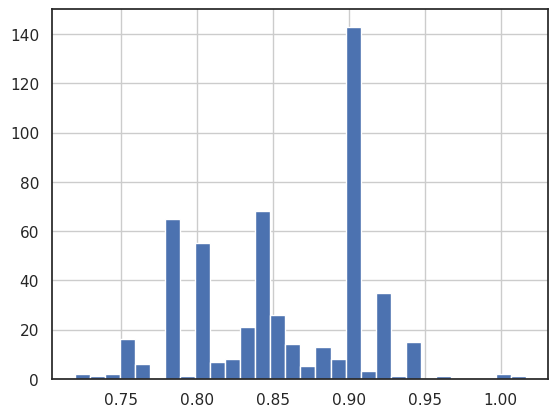

In [19]:
model_data_no_journal['y_norm'] = y_norm

print(f"Number of <0 predictions: {(model_data_no_journal['y_norm'] < 0).sum()}")
print(f"Number of periods where predictions sums >1 : {(model_data_no_journal.groupby('month')['y_norm'].sum() > 1).sum()}")

model_data_no_journal.groupby('month')['y_norm'].sum().hist(bins=30)

In [20]:
model_data_no_journal['extreme_dummy'] = np.where(
    model_data_no_journal['political_alignment'].str.contains('Far', case=False, na=False),
    1, 0)

regressors = ["na_share", "pres_votes_share", "government", "extreme_dummy"]
X = model_data_no_journal[regressors]
X = sm.add_constant(X)
y = model_data_no_journal[outcome]
model = sm.OLS(y, X).fit(cov_type='HC3')

y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
mape = mean_ape(y, y_pred)
mrr = mean_rr(y, y_pred)
rmspe = root_mse(y, y_pred)

params = model.params.rename("coef").to_frame()
pvalues = model.pvalues.rename("pval").to_frame()
print(pd.merge(params, pvalues, left_index=True, right_index=True))
print("")
print(f"R2: {100*r2:.2f}%")
print(f"MAPE: {100*mape:.2f}%")
print(f"MRR: {100*mrr:.2f}%")
print(f"RMSPE: {rmspe:.5f}")

                      coef           pval
const             0.030752   4.196436e-22
na_share          0.599721  2.764949e-170
pres_votes_share  0.506624   4.845070e-76
government        0.046941   2.367222e-06
extreme_dummy    -0.064174   1.220508e-54

R2: 86.61%
MAPE: 73.12%
MRR: 9.77%
RMSPE: 0.08617


En estimant directement ce modèle, les coefficients obtenus sont très proches ($\alpha = 0,015$ au lieu de $0,01$, $\beta = 0,73$ au lieu de $0,655$ et $\gamma = 0,29$ au lieu de $0,325$) et les performances prédictives également (avec une erreur absolue moyenne inférieure de 4,3 %, des résidus relatifs moyens inférieurs de 55,2 %, et une erreur quadratique moyenne inférieure de 27,6 %). Cela confirme que notre spécification est recevable, car elle correspond de près aux tendances apparaissant dans les données.

*Illustration ci-dessous des incohérences engendrées par l'absence de prise en compte de la compositionnalité des données : les proportions des citations prédites pour chaque période devraient sommer à 1, mais ce n'est pas toujours le cas. La modalité autres est exclue des nuances politiques, mais la réintégrer ne change pas l'aspect des résultats.*

Number of <0 predictions: 55
Number of periods where predictions sums >1: 287


<Axes: >

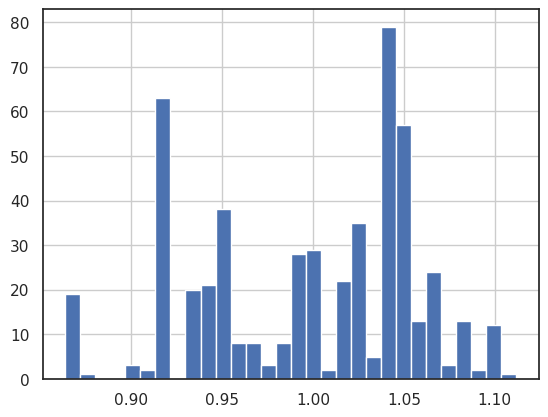

In [21]:
model_data_no_journal['y_pred'] = model.predict(sm.add_constant(model_data_no_journal[regressors]))

print(f"Number of <0 predictions: {(model_data_no_journal['y_pred'] < 0).sum()}")
print(f"Number of periods where predictions sums >1: {(model_data_no_journal.groupby('month')['y_pred'].sum() > 1).sum()}")

model_data_no_journal.groupby('month')['y_pred'].sum().hist(bins=30)

*Comparaison avec d'autres modèles*

In [22]:
cutoff = pd.Period('2017-06', freq='M')

X = model_data_no_journal[model_data_no_journal["month"] < cutoff][["na_share", "pres_votes_share", "government"]]
X = sm.add_constant(X)
y = model_data_no_journal[model_data_no_journal["month"] < cutoff][outcome]
model = sm.OLS(y, X).fit(cov_type='HC3')

y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
mape = mean_ape(y, y_pred)
mrr = mean_rr(y, y_pred)
rmspe = root_mse(y, y_pred)

params = model.params.rename("coef").to_frame()
pvalues = model.pvalues.rename("pval").to_frame()
print(pd.merge(params, pvalues, left_index=True, right_index=True))
print("")
print(f"R2: {100*r2:.2f}%")
print(f"MAPE: {100*mape:.2f}%")
print(f"MRR: {100*mrr:.2f}%")
print(f"RMSPE: {rmspe:.5f}")

                      coef           pval
const            -0.009382   1.542259e-04
na_share          0.692753  5.025772e-278
pres_votes_share  0.463160   9.896939e-64
government        0.070097   1.530523e-11

R2: 89.94%
MAPE: 78.60%
MRR: -53.62%
RMSPE: 0.08005


Ce résultat tient si on restreint l'estimation à la période antérieure à juin 2017, dans l'hypothèse où la norme de représentativité aurait prévalu nettement jusque là, mais se serait érodée ensuite. Les écarts avec le modèle *a priori* s'accentuent encore légèrement concernant les coefficients, mais évoluent de manière contrastée concernant les performances prédictives (avec une réduction de la RMSPE mais une augmentation de la MAPE et des MRR, signifiant que le modèle devient plus efficace pour les valeurs extrêmes, mais moins efficace pour les valeurs courantes).

In [23]:
cutoff = pd.Period('2012-06', freq='M')

X = model_data[(model_data['journal'] == 'Le Monde') & (model_data["month"] < cutoff)][["na_share", "pres_votes_share", "government"]]
X = sm.add_constant(X)
y = model_data[(model_data['journal'] == 'Le Monde') & (model_data["month"] < cutoff)][outcome]
model = sm.OLS(y, X).fit(cov_type='HC3')

y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
mape = mean_ape(y, y_pred)
mrr = mean_rr(y, y_pred)
rmspe = root_mse(y, y_pred)

params = model.params.rename("coef").to_frame()
pvalues = model.pvalues.rename("pval").to_frame()
print(pd.merge(params, pvalues, left_index=True, right_index=True))
print("")
print(f"R2: {100*r2:.2f}%")
print(f"MAPE: {100*mape:.2f}%")
print(f"MRR: {100*mrr:.2f}%")
print(f"RMSPE: {rmspe:.5f}")

KeyError: 'journal'

On obtient encore des résultats proches si l'on se restreint au Monde avant juin 2012.

# 1. Ecarts à la norme de représentativité selon les nuances politiques

In [ ]:
model_data_no_journal['y_norm'] = (
    alpha +
    beta * (1 - n*alpha - theta) * model_data_no_journal["na_share"] + 
    gamma * (1 - n*alpha - theta) * model_data_no_journal["pres_votes_share"] +
    theta * model_data_no_journal["government"])
model_data_no_journal['abs_residuals'] = 100 * (model_data_no_journal[outcome] - model_data_no_journal['y_norm'])
model_data_no_journal['rel_residuals'] = 100 * (model_data_no_journal[outcome] - model_data_no_journal['y_norm']) / model_data_no_journal['y_norm']

In [ ]:
summary_list = []

for alignment in model_data_no_journal['political_alignment'].unique():
    subset_data = model_data_no_journal[model_data_no_journal['political_alignment'] == alignment]
    y = subset_data[outcome]
    y_norm = subset_data['y_norm']
    mape = mean_ape(y, y_norm)
    mrr = mean_rr(y, y_pred)
    rmspe = root_mse(y, y_norm)
    summary_list.append({
        'Political alignment': alignment,
        'MAPE': mape,
        'MRR': mrr,
        'RMSPE': rmspe
    })

summary = pd.DataFrame(summary_list)
summary["Political alignment"] = pd.Categorical(summary["Political alignment"], categories=nuances_order, ordered=True)
summary.style.hide(axis=0)

Dans quelle mesure les journalistes respectent-ils la norme de représentativité concernant différentes nuances politiques ?
- Etroitement concernant la droite et la gauche (avec une MAPE plus élevée pour la gauche, mais des MRR quasi-nuls, montrant que les écarts à la norme se compensent en moyenne)
- Moyennement concernant l'extrême droite et l'extrême gauche, avec des MAPE et des MRR entre 40 et 65 % en valeur absolue (mais des MRR de signes opposés, témoignant d'écarts à la norme favorables à l'extrême droite et défavorables à l'extrême gauche)
- Faiblement pour le centre, avec une MAPE plus de 10 fois supérieure à celle de la droite (et des MRR positifs témoignant d'écarts favorables)

Dans l'ensemble, la norme de représentativité semble davantage respectée pour les nuances politiques au pouvoir, c'est-à-dire essentiellement la droite et la gauche entre 1981 et 2024.

In [ ]:
cutoff1 = pd.Period('2002-06', freq='M')
cutoff2 = pd.Period('2017-06', freq='M')

models = {}

for period_label, period_filter in {
    '1981-2002': model_data_no_journal["month"] < cutoff1,
    '2002-2017': (model_data_no_journal["month"] >= cutoff1) & (model_data_no_journal["month"] < cutoff2),
    '2017-2024': model_data_no_journal["month"] >= cutoff2
}.items():
    
    models[period_label] = {}
    period_data = model_data_no_journal[period_filter]
    
    for alignment in period_data["political_alignment"].unique():
        models[period_label][alignment] = {}
        subset = period_data[period_data["political_alignment"] == alignment]

        if len(subset) >= 3:
            y = subset[outcome]
            y_norm = subset['y_norm']
            mape = mean_ape(y, y_norm)
            mrr = mean_rr(y, y_norm)
            rmspe = root_mse(y, y_norm)

            models[period_label][alignment] = {
                "MAPE": mape,
                "MRR": mrr,
                "RMSPE": rmspe}

        else:
            models[period_label][alignment] = {
                "MAPE": None,
                "MRR": None,
                "RMSPE": None}

In [ ]:
summary_list = []

for period, alignment_dict in models.items():
    for alignment, model_info in alignment_dict.items():
        summary_list.append({
            "period": period,
            "alignment": alignment,
            "mape": model_info["MAPE"],
            "mrr": model_info["MRR"],
            "rmspe": model_info["RMSPE"]
        })

summary = pd.DataFrame(summary_list)
summary["alignment"] = pd.Categorical(summary["alignment"], categories=nuances_order, ordered=True)
summary = summary.pivot_table(index="alignment",
                                      columns="period",
                                      values=["mape", "mrr", "rmspe"],
                                      observed=False)
summary = summary.reset_index()
summary.columns.names = [None, None]

format_cols = summary.columns[1:]
summary.style.hide(axis="index").format({col: "{:.3f}" for col in format_cols})

Les évolutions temporelles des écarts à la norme de représentativité font apparaître un tableau plus complexe, notamment à cause de variations brutales concernant le centre et la gauche, témoignant d'une couverture médiatique qui leur serait massivement favorable, respectivement, en 2002-2017 et 2017-2024.

La couverture de l'extrême droite est marquée par une convergence forte vers la norme de représentatitivé entre les deux premières périodes, avec des MAPE et des MRR divisés par 2 environ. Le traitement de cette nuance, d'abord favorable, serait ainsi devenu neutre.

La couverture de l'extrême gauche est marquée par une légère convergence entre les deux dernières périodes, avec des MRR demeurant très négatifs, témoingnant d'un traitement défavorable.

Quant à la droite, sa couverture demeure stable, au plus près de la norme de représentativité.

In [ ]:
plot_data = model_data_no_journal.copy()
plot_data['month'] = plot_data['month'].dt.to_timestamp()

alignment_groups = [
    (['Far left', 'Far right'],
     {'Far left': 'crimson',
      'Far right': 'royalblue'}),
    (['Right', 'Left', 'Center'],
     {'Right': 'cornflowerblue',
      'Left': 'orchid',
      'Center': 'goldenrod'})]

In [ ]:
alignment = 'Far right'
subset_data = plot_data[plot_data['political_alignment'] == alignment].copy()
subset_data['MA_observed'] = subset_data[outcome].rolling(window=12).mean()
subset_data['MA_rel'] = subset_data['rel_residuals'].rolling(window=12).mean()

fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

sns.lineplot(data=subset_data, x='month', y=outcome, ax=axes[0], label='Observed values', alpha=0.15, color='royalblue', linestyle='-')
sns.lineplot(data=subset_data, x='month', y='MA_observed', ax=axes[0], label='12 months moving average for OV', color='royalblue', linestyle='dashdot')
sns.lineplot(data=subset_data, x='month', y='y_norm', ax=axes[0], label='Predicted values', color='teal', linestyle='dotted')
axes[0].set_title("Observed and Predicted Values")
axes[0].set_ylabel('')

sns.lineplot(data=subset_data, x='month', y='rel_residuals', ax=axes[1], label='Relative residuals', alpha=0.15, color='royalblue', linestyle='-')
sns.lineplot(data=subset_data, x='month', y='MA_rel', ax=axes[1], label='12 months moving average for RR', color='royalblue', linestyle='dashdot')
sns.lineplot(data=subset_data, x='month', y='y_norm', ax=axes[1], label='Predicted values', color='teal', linestyle='dotted')
axes[1].set_title("Relative Residuals (%)")
axes[1].set_xlabel('')
axes[1].set_ylabel('')

add_shaded_periods(axes, main_elec_months, color='black', alpha=0.1)

plt.suptitle("Proportion of Quotes Attributed to Far-Right Politicians")
plt.tight_layout()
plt.show()

Concernant spécifiquement l'extrême droite, on n'observe pas d'augmentation tendancielle des résidus relatifs, qui témoignerait d'une application de plus en plus laxiste de la norme de représentativité, dans un sens favorable.

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

for ax, (political_alignments, colors) in zip(axes, alignment_groups):
    alignment_handles = []

    for alignment in political_alignments:
        subset_data = plot_data[plot_data['political_alignment'] == alignment].copy()
        subset_data['MA'] = subset_data[outcome].rolling(window=6).mean()
        
        ax.plot(subset_data['month'], subset_data[outcome], label=None,
                alpha=0.2, color=colors[alignment], linestyle='-')
        ax.plot(subset_data['month'], subset_data['MA'], label=None,
                alpha=0.65, color=colors[alignment], linestyle='dashdot')
        ax.plot(subset_data['month'], subset_data['y_norm'], label=None,
                alpha=1, color=colors[alignment], linestyle='dotted')
        
        alignment_handles.append(Line2D([0], [0], color=colors[alignment], lw=2, label=alignment))

    alignment_legend = ax.legend(handles=alignment_handles, title="Political alignment", loc="upper left")
    ax.add_artist(alignment_legend)

    line_type_handles = [
        Line2D([0], [0], color='black', lw=2, linestyle='-', label="Monthly average"),
        Line2D([0], [0], color='black', lw=2, linestyle='dashdot', label="6 months moving average"),
        Line2D([0], [0], color='black', lw=2, linestyle='dotted', label="Predictions")]
    ax.legend(handles=line_type_handles, title="Values", loc="upper right")

axes[-1].set_xlabel("")

add_shaded_periods(axes, main_elec_months, color='black', alpha=0.1)

plt.suptitle("Quote Distribution by Political Affiliation\nObserved vs. Predicted Values")
plt.tight_layout()
plt.savefig("output/nuances_val_graph.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

for ax, (political_alignments, colors) in zip(axes, alignment_groups):
    alignment_handles = []

    for alignment in political_alignments:
        subset_data = plot_data[plot_data['political_alignment'] == alignment].copy()
        subset_data['MA'] = subset_data['rel_residuals'].rolling(window=6).mean()
        
        ax.plot(subset_data['month'], subset_data['rel_residuals'], label=None,
                alpha=0.2, color=colors[alignment], linestyle='-')
        ax.plot(subset_data['month'], subset_data['MA'], label=None,
                alpha=0.65, color=colors[alignment], linestyle='-.')
        ax.plot(subset_data['month'], [0] * len(subset_data), label=None,
                alpha=1, color='darkgray', linestyle=':')
        
        alignment_handles.append(Line2D([0], [0], color=colors[alignment], lw=2, label=alignment))

    alignment_legend = ax.legend(handles=alignment_handles, title="Political alignment", loc="upper left")
    ax.add_artist(alignment_legend)

    line_type_handles = [
        Line2D([0], [0], color='black', lw=2, linestyle='-', label="Monthly average"),
        Line2D([0], [0], color='black', lw=2, linestyle='-.', label="6 months moving average"),
        Line2D([0], [0], color='black', lw=2, linestyle=':', label="Predictions")
    ]
    ax.legend(handles=line_type_handles, title="Values", loc="upper right")

axes[-1].set_xlabel("")

add_shaded_periods(axes, main_elec_months, color='black', alpha=0.1)

plt.suptitle("Quote Distribution by Political Affiliation\nRelative Residuals (%)")
plt.tight_layout()
plt.savefig("output/nuances_res_graph.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

for ax, (political_alignments, colors) in zip(axes, alignment_groups):
    alignment_handles = []

    for alignment in political_alignments:
        subset_data = plot_data[plot_data['political_alignment'] == alignment].copy()
        subset_data['MA'] = subset_data['abs_residuals'].rolling(window=6).mean()
        
        ax.plot(subset_data['month'], subset_data['abs_residuals'], label=None,
                alpha=0.2, color=colors[alignment], linestyle='-')
        ax.plot(subset_data['month'], subset_data['MA'], label=None,
                alpha=0.65, color=colors[alignment], linestyle='-.')
        ax.plot(subset_data['month'], [0] * len(subset_data), label=None,
                alpha=1, color='darkgray', linestyle=':')
        
        alignment_handles.append(Line2D([0], [0], color=colors[alignment], lw=2, label=alignment))

    alignment_legend = ax.legend(handles=alignment_handles, title="Political alignment", loc="upper left")
    ax.add_artist(alignment_legend)

    line_type_handles = [
        Line2D([0], [0], color='black', lw=2, linestyle='-', label="Monthly average"),
        Line2D([0], [0], color='black', lw=2, linestyle='-.', label="6 months moving average"),
        Line2D([0], [0], color='black', lw=2, linestyle=':', label="Predictions")
    ]
    ax.legend(handles=line_type_handles, title="Values", loc="upper right")

axes[-1].set_xlabel("")

add_shaded_periods(axes, main_elec_months, color='black', alpha=0.1)

plt.suptitle("Quote Distribution by Political Affiliation\nAbsolute Residuals (%)")
plt.tight_layout()
plt.savefig("output/nuances_abs_graph.png", dpi=300, bbox_inches='tight')
plt.show()

Le résultat le plus flagrant est la présence de deux dynamiques non-capturées : 
- L'une pour l'extrême-droite entre 1983 et 1985. L'année 1984 correspond au premier succès du Front national lors d'une élection nationale. Or, il s'agit des européennes, dont les résultats ne sont pas intégrés notre modèle normatif. Lorsque l'on exclut la période correspondante, les MAPE du modèle *a priori* deviennent équivalente pour l'extrême droite et l'extrême gauche (mais avec des MRR toujours bien plus négatifs pour la seconde) (cf. *infra*).
- L'autre pour le centre entre 2007 et 2017. Ici, le décalage entre les comportements réels et prescrits est plus difficilement explicable. L'année 2007 est marquée par la percée de François Bayrou lors des élections présidentielles, qui arrive 3e avec 18,57 % des voix, et l'année 2017 par la victoire d'Emmanuel Macron à ces mêmes élections. Mais les résultats de ces dernières sont bien pris en compte par notre modèle normatif. Alors... ? Observons nous ici un fort engagement des rédactions en faveur du centre ? Ou cette impression résulte-t-elle de problèmes dans les données ?

On constate aussi l'existence d'une prime à la majorité pour les partis accédant au pouvoir, qui reçoivent toujours davantage de citations que prescrit pas notre modèle. Mais curieusement, l'ajout de la nuance politique du Premier ministre aux modèles estimés n'améliore pas leurs performances prédictives (cf. *infra*).

Enfin, aucun biais systématique n'apparaît dans la couverture médiatique des nuances politiques, sauf en défaveur de l'extrême gauche.

In [ ]:
summary_list = []

for alignment in model_data_no_journal['political_alignment'].unique():
    subset_data = model_data_no_journal[(model_data_no_journal['political_alignment'] == alignment) & (model_data_no_journal["month"] > pd.Period('1988-01', freq='M'))]
    y = subset_data[outcome]
    y_norm = subset_data['y_norm']
    mape = mean_ape(y, y_norm)
    mrr = mean_rr(y, y_pred)
    rmspe = root_mse(y, y_norm)
    summary_list.append({
        'Political alignment': alignment,
        'MAPE': mape,
        'MRR': mrr,
        'RMSPE': rmspe
    })

summary = pd.DataFrame(summary_list)
summary["Political alignment"] = pd.Categorical(summary["Political alignment"], categories=nuances_order, ordered=True)
summary.style.hide(axis=0)

In [ ]:
X = model_data_no_journal[["na_share", "pres_votes_share", "government"]]
X = sm.add_constant(X)
y = model_data_no_journal[outcome]
model = sm.OLS(y, X).fit(cov_type='HC3')

y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
mape = mean_ape(y, y_pred)
mrr = mean_rr(y, y_pred)
rmspe = root_mse(y, y_pred)

params = model.params.rename("coef").to_frame()
pvalues = model.pvalues.rename("pval").to_frame()
print(pd.merge(params, pvalues, left_index=True, right_index=True))
print("")
print(f"R2: {100*r2:.2f}%")
print(f"MAPE: {100*mape:.2f}%")
print(f"MRR: {100*mrr:.2f}%")
print(f"RMSPE: {rmspe:.5f}")

*Tentative pour calculer la proportion des proportions de citations correctement prescrites...*
- *Correct prescriptions = proportion des citations prescrites correspondant à des citations réelles*
- *Excess prescriptions = proportion des citations prescrites excédant les citations réelles*
- *True missing = proportion des citations réelles non-prescrites par le modèle a priori*

In [ ]:
def compute_proportional_metrics(y_norm, y_true):
    y_norm = np.array(y_norm)
    y_true = np.array(y_true)
    
    # Initialize arrays
    TP = np.zeros_like(y_norm)
    TN = np.zeros_like(y_norm)
    FP = np.zeros_like(y_norm)
    FN = np.zeros_like(y_norm)
    
    # Calculate difference
    diff = y_norm - y_true
    
    # Case 1: y_norm - y_true = 0 (perfect prediction)
    perfect_mask = (diff == 0)
    TP[perfect_mask] = 1
    FP[perfect_mask] = 0
    FN[perfect_mask] = 0
    
    # Case 2: y_norm - y_true > 0 (over-prediction)
    over_mask = (diff > 0)
    TP[over_mask] = y_true[over_mask] / y_norm[over_mask]
    FP[over_mask] = diff[over_mask] / y_norm[over_mask]
    FN[over_mask] = 0
    
    # Case 3: y_norm - y_true < 0 (under-prediction)
    under_mask = (diff < 0)
    TP[under_mask] = 1
    FN[under_mask] = - diff[under_mask] / y_true[under_mask]
    FP[under_mask] = 0
    
    return {
        'TP': TP.mean(),
        'FP': FP.mean(),
        'FN': FN.mean()}

summary_list = []

for alignment in model_data_no_journal['political_alignment'].unique():
    subset_data = model_data_no_journal[model_data_no_journal['political_alignment'] == alignment]
    y = subset_data[outcome]
    y_norm = subset_data['y_norm']
    metrics = compute_proportional_metrics(y_norm, y)
    summary_list.append({
        'Political alignment': alignment,
        '% correct prescriptions': 100 * metrics['TP'],
        '% excess prescriptions': 100 * metrics['FP'],
        '% true missing': 100 * metrics['FN']})

summary = pd.DataFrame(summary_list)
summary["Political alignment"] = pd.Categorical(summary["Political alignment"], categories=nuances_order, ordered=True)
summary.style.hide(axis=0)

# 2. Ecarts à la norme de représentativité selon les journaux

In [ ]:
model_data['y_norm'] = y_norm = (
    alpha +
    beta * (1 - n*alpha - theta) * model_data_no_journal["na_share"] + 
    gamma * (1 - n*alpha - theta) * model_data_no_journal["pres_votes_share"] +
    theta * model_data_no_journal["government"])
model_data['abs_residuals'] = 100 * (model_data[outcome] - model_data['y_norm'])
model_data['rel_residuals'] = 100 * (model_data[outcome] - model_data['y_norm']) / model_data['y_norm']

In [ ]:
summary = []

for journal in model_data['journal'].unique():
    subset_data = model_data[model_data['journal'] == journal]
    y = subset_data[outcome]
    y_norm = subset_data['y_norm']
    mape = mean_ape(y, y_norm)
    mrr = mean_rr(y, y_norm)
    rmspe = root_mse(y, y_norm) / y.mean()
    summary.append({
        'Journal': journal,
        'MAPE': mape,
        'MRR': mrr,
        'RMSPE': rmspe})

pd.DataFrame(summary).style.hide(axis=0)

Trois groupes de journaux apparaissent :
- Le Figaro et Le Monde respectent le plus la norme de représentativité
- La Croix et Libération la respectent un peu moins
- Médiapart s'en écarte plus franchement

In [ ]:
results = []

for journal in model_data['journal'].unique():
    for alignment in model_data['political_alignment'].unique():
        subset_data = model_data[(model_data['journal'] == journal) & (model_data['political_alignment'] == alignment)]
        y = subset_data[outcome]
        y_norm = subset_data['y_norm']
        mape = mean_ape(y, y_norm)
        mrr = mean_rr(y, y_norm)
        rmspe = root_mse(y, y_norm)
        results.append({
            "alignment": alignment,
            "journal": journal,
            'MAPE': mape,
            'MRR': mrr,
            'RMSPE': rmspe})

results = pd.DataFrame(results)
results["alignment"] = pd.Categorical(results["alignment"], categories=nuances_order, ordered=True)
results = results.sort_values(["alignment", "journal"])
results = results.set_index(["alignment", "journal"])
results.index.names = ["Political Alignment", "Journal"]

results.style.format("{:.4f}")

Le traitement du centre par La Croix et de la gauche par Libération semble responsable de leur déviation supérieure par rapport au Monde et au Figaro. Médiapart se distingue en citant davantage l'extrême gauche, mais plus encore l'extrême droite.

In [ ]:
plot_data = model_data.copy()
plot_data['month'] = plot_data['month'].dt.to_timestamp()

colors = {
    'Le Figaro': 'goldenrod',
    'Libération': 'limegreen',
    'Le Monde': 'orchid',
    'La Croix': 'skyblue',
    'Médiapart': 'crimson'}

alignments = [
    "Far right",
    "Right",
    "Center",
    "Left",
    "Far left"]

n_alignments = len(alignments)

In [ ]:
fig, axes = plt.subplots(n_alignments, 1, figsize=(16, 4 * n_alignments), sharex=True)

for i, alignment in enumerate(alignments):
    ax = axes[i]
    subset_data = plot_data[plot_data['political_alignment'] == alignment]

    for journal in subset_data['journal'].unique():
        if journal == 'Médiapart': continue
        sub_subset_data = subset_data[subset_data['journal'] == journal].copy()
        sub_subset_data['MA'] = sub_subset_data[outcome].rolling(window=12).mean()
        ax.plot(sub_subset_data['month'], sub_subset_data[outcome], label=journal,
                alpha=0.7, color=colors[journal], linestyle='-')

    ax.plot(subset_data['month'], subset_data['y_norm'], color='black', alpha=0.8, linestyle='dotted')
    ax.set_title(f"{alignment}")
    ax.legend()

add_shaded_periods(axes, main_elec_months, color='black', alpha=0.1)

plt.suptitle("""
Quote Distribution by Political Affiliation and Journal\n
Observed vs. Predicted Values
""")
plt.tight_layout()
plt.savefig("output/journals_val_graph.png", dpi=300, bbox_inches='tight')
plt.show()

Médiapart est exclu des graphs car ses données semblent assez erratiques jusqu'en 2012 : le nombre d'articles publiés est probablement faible, ce qui conduit à atteindre régulièrement des proportions de 1 pour certaines nuances politiques.

On retrouve de manière plus visible que dans le tableau les différences éditoriales auxquelles on pouvait s'attendre : le Figaro et la Croix couvrent davantage la droite que le Monde et Libération, et inversement pour la gauche et l'extrême gauche. Concernant l'extrême droite, aucune différence flagrante n'apparaît.

In [ ]:
fig, axes = plt.subplots(n_alignments, 1, figsize=(16, 4 * n_alignments), sharex=True)

for i, alignment in enumerate(alignments):
    ax = axes[i]
    subset_data = plot_data[plot_data['political_alignment'] == alignment]

    for journal in subset_data['journal'].unique():
        sub_subset_data = subset_data[subset_data['journal'] == journal].copy()
        sub_subset_data['MA'] = sub_subset_data['rel_residuals'].rolling(window=12).mean()
        ax.plot(sub_subset_data['month'], sub_subset_data['MA'], label=journal,
                alpha=0.7, color=colors[journal], linestyle='-')

    ax.plot(subset_data['month'], subset_data['y_norm'], color='black', alpha=0.8, linestyle='dotted')
    ax.set_title(f"{alignment}")
    ax.legend()

add_shaded_periods(axes, main_elec_months, color='black', alpha=0.1)

plt.suptitle("""
Quote Distribution by Political Affiliation and Journal\n
Relative Residuals (%) - 12 months moving averages
""")
plt.tight_layout()
plt.savefig("output/journals_res_graph.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
model_data_no_journal.columns

In [ ]:
(0.021988-0.013285)/0.013285

In [ ]:
model_data_no_journal[model_data_no_journal['political_alignment'] == 'Far right'][['month', 'quotes_share', 'y_norm', 'rel_residuals']].head(n=60)